In [217]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
import fsspec
import math
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression

plt.rcParams['figure.figsize'] = (16,8)

#### - According to the paper "Characteristics of Surface Solar Radiation under Different Air Pollution Conditions over Nanjing, China: Observation and Simulation", PM 2.5 affects surface solar radiation (global radiation at surface) by increasing scattered radiation and it exerts the biggest effect among all particle matters in different sizes.

#### - Global horizontal radiation = direct normal radiation * cos(θ) + diffuse horizontal radiation, where θ is the solar zenith angle and cos(θ) = 0.5 is widely used for daytime-average (from paper "On the Choice of Average Solar Zenith Angle"). And since solar panels can only convert the direct normal radiation to power, higher PM 2.5 concentration will also lead to decrease in PV power generation, as stated in the paper "The effect of particulate matter on solar photovoltaic power generation over the Republic of Korea".

#### - I would like to visualize the effects of PM 2.5 on diffuse radiation and it's correlation with the diffuse fraction(= diffuse irradiance/global irradiance) by examinning irradiance data and air quality data in 2016 over the New York State.

### 1. Visualizing Global Horizontal Irradiance (GHI) and Direct Normal Irradiance (DNI) Data over the US and the New York State

- Read GHI and DNI data from Google Drive. These two CSV files contain annual average irradiance values over North America. 

In [2]:
url1 = 'https://docs.google.com/uc?export=download&id=1t3EoGgaMc-nF6gyx1QjLdBoON3w-eezV'
ghi = pd.read_csv(url1)
ghi.head()

GHI  GID        LON        LAT
0  5.544    1 -56.740002   3.934100
1  5.616    2 -56.740002   0.094101
2  5.496    3 -56.459999 -15.385900
3  5.520    4 -56.419998   4.854100
4  5.544    5 -56.340000  -2.305900

In [3]:
url2 = 'https://docs.google.com/uc?export=download&id=1-A3DzYEXPnvraSTTtxFi53XvS71_Z88B'
dni = pd.read_csv(url2)
dni.head()

DNI  GID        LON        LAT
0  4.896    1 -56.740002   3.934100
1  4.920    2 -56.740002   0.094101
2  5.280    3 -56.459999 -15.385900
3  4.824    4 -56.419998   4.854100
4  4.704    5 -56.340000  -2.305900

- Convert GHI data to a 2D-array 

In [4]:
df = ghi.set_index(['LAT', 'LON'])
ghi_xr = df.to_xarray()
ghi_xr

<xarray.Dataset>
Dimensions:  (LAT: 2025, LON: 3826)
Coordinates:
  * LAT      (LAT) float64 -20.99 -20.95 -20.91 -20.87 ... 59.89 59.93 59.97
  * LON      (LON) float64 -180.0 -179.9 -179.9 -179.9 ... 179.8 179.8 179.9
Data variables:
    GHI      (LAT, LON) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    GID      (LAT, LON) float64 nan nan nan nan nan nan ... nan nan nan nan nan

- Convert DHI data to a 2D-array

In [5]:
df = dni.set_index(['LAT', 'LON'])
dni_xr = df.to_xarray()
dni_xr

<xarray.Dataset>
Dimensions:  (LAT: 2025, LON: 3826)
Coordinates:
  * LAT      (LAT) float64 -20.99 -20.95 -20.91 -20.87 ... 59.89 59.93 59.97
  * LON      (LON) float64 -180.0 -179.9 -179.9 -179.9 ... 179.8 179.8 179.9
Data variables:
    DNI      (LAT, LON) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    GID      (LAT, LON) float64 nan nan nan nan nan nan ... nan nan nan nan nan

- Visualize two datasets over US

Text(0.5, 1.0, 'Average Direct Normal Irradiance over US in 2016')

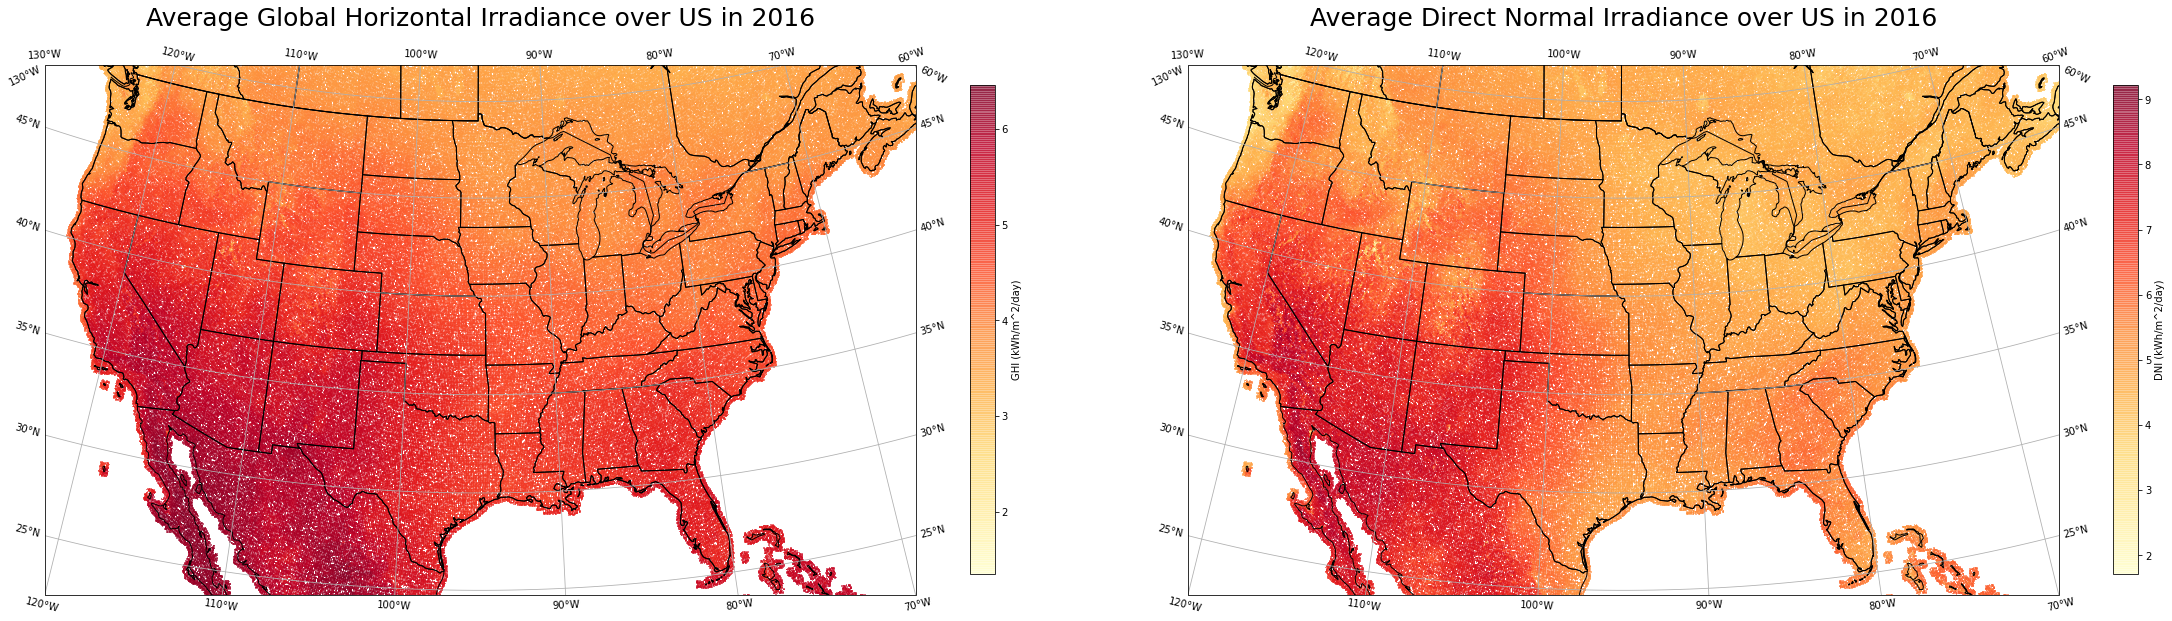

In [6]:
extent = [-120, -70, 22, 50]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
fig, axes = plt.subplots(ncols=2,figsize=(40,30))
plt.subplots_adjust(wspace=0.05)

#GHI over US plot

ax0=plt.subplot(1,2,1,projection=ccrs.AlbersEqualArea(central_lon,central_lat))
ax0.set_extent(extent)
ax0.gridlines(draw_labels=True)
ax0.coastlines(resolution='50m')
ax0.add_feature(cfeature.BORDERS)
ax0.add_feature(cfeature.STATES)

US_ghi = ghi_xr.sel(LAT=slice(22,52),LON=slice(-130,-60))
US_ghi.GHI.plot(ax=ax0,cmap='YlOrRd',vmin=np.min(US_ghi.GHI), vmax=np.max(US_ghi.GHI),transform=ccrs.PlateCarree(),alpha=0.6,cbar_kwargs={'shrink': 0.3,'label':'GHI (kWh/m^2/day)'})
ax0.set_title('Average Global Horizontal Irradiance over US in 2016',fontsize='25',pad='20')

#DNI over US plot

ax1 = plt.subplot(1,2,2,projection=ccrs.AlbersEqualArea(central_lon,central_lat))
ax1.set_extent(extent)
ax1.gridlines(draw_labels=True)
ax1.coastlines(resolution='50m')
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.STATES)

US_dni = dni_xr.sel(LAT=slice(22,52),LON=slice(-130,-60))
US_dni.DNI.plot(ax=ax1,cmap='YlOrRd',vmin=np.min(US_dni.DNI), vmax=np.max(US_dni.DNI),transform=ccrs.PlateCarree(),alpha=0.6,cbar_kwargs={'shrink': 0.3,'label':'DNI (kWh/m^2/day)'})
ax1.set_title('Average Direct Normal Irradiance over US in 2016',fontsize='25',pad='20')

#### Notice that the maximum of direct normal irradiance is larger than that of global horizontal irradiance. We need to multiply the direct normal irradiance with cos(θ) (=0.5) when calculating the diffuse irradiance later. 

- Close up to New York State

Text(0.5, 1.0, 'Average Direct Normal Irradiance over New York State in 2016')

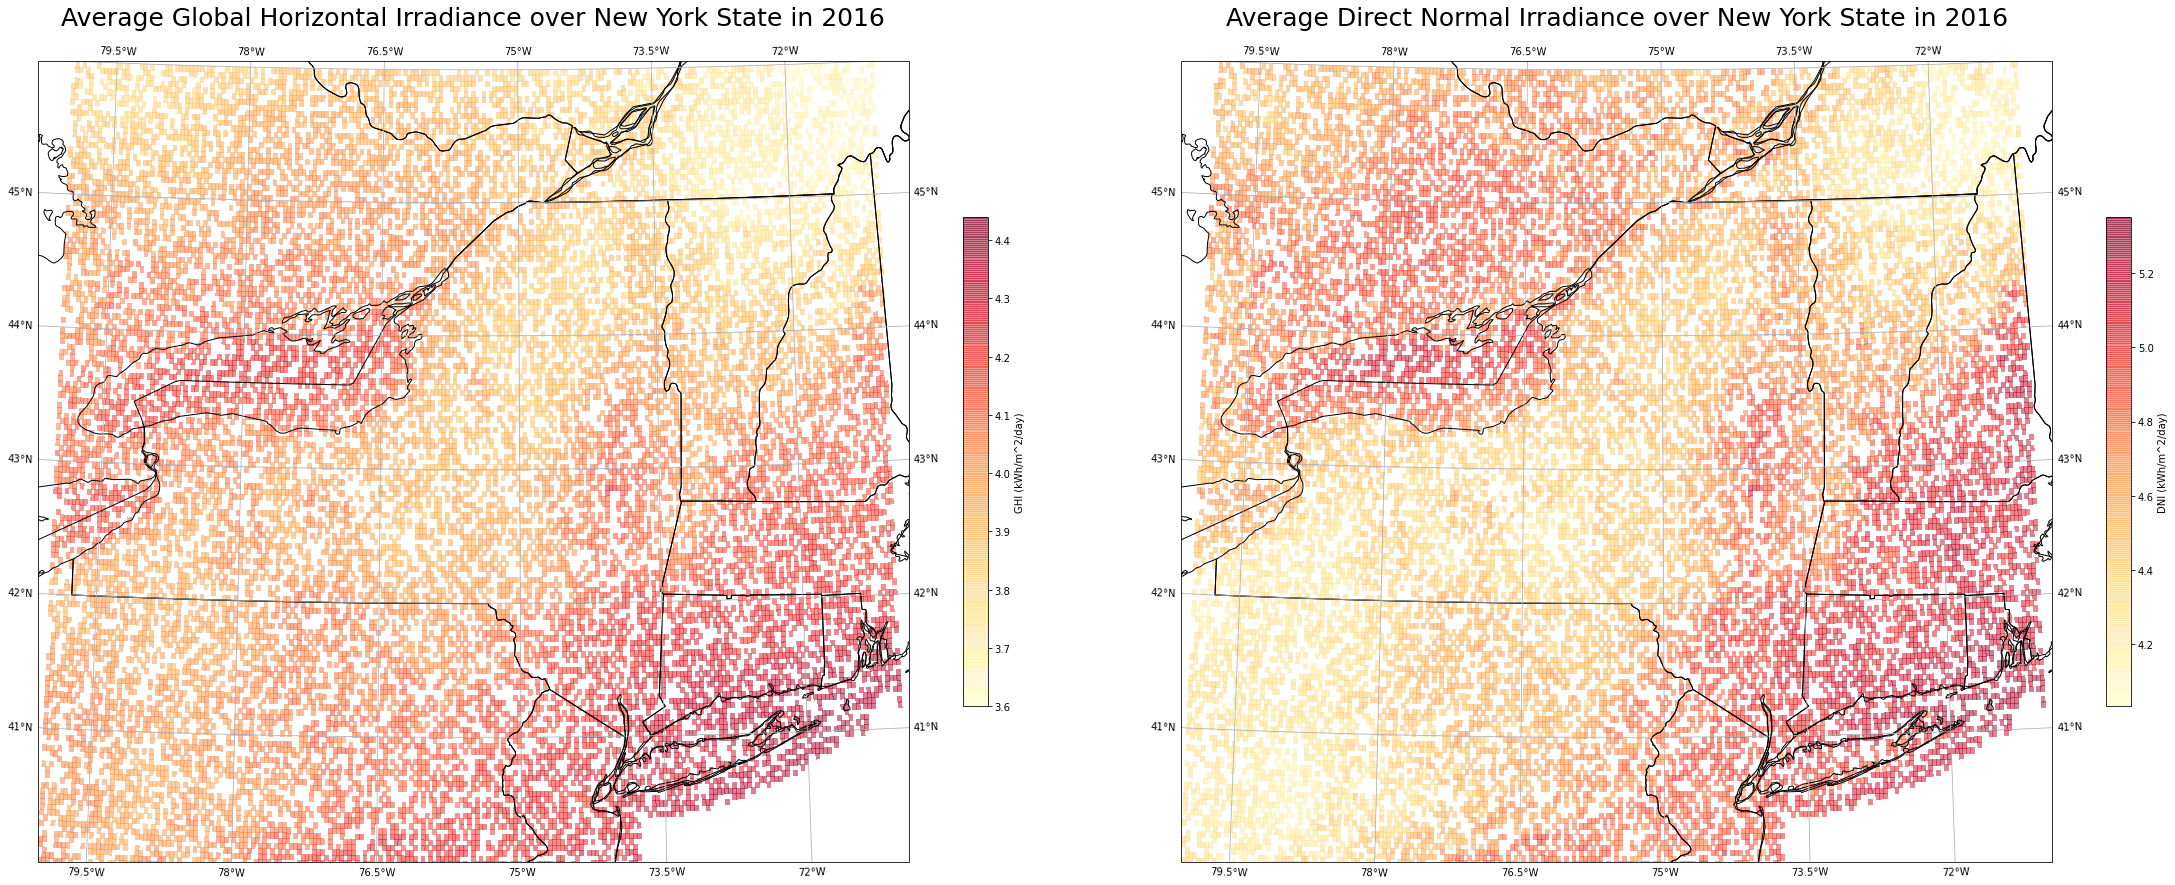

In [7]:
extent = [-80,-71, 40,46]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
fig, axes = plt.subplots(ncols=2,figsize=(40,30))
plt.subplots_adjust(wspace=0.05)

#GHI over NY plot

ax0 = plt.subplot(1,2,1,projection=ccrs.AlbersEqualArea(central_lon,central_lat))
ax0.set_extent(extent)
ax0.gridlines(draw_labels=True)
ax0.coastlines(resolution='50m')
ax0.add_feature(cfeature.BORDERS)
ax0.add_feature(cfeature.STATES)

NY_ghi = ghi_xr.sel(LAT=slice(40,46),LON=slice(-80,-71))
NY_ghi.GHI.plot(ax=ax0,cmap='YlOrRd',vmin=np.min(NY_ghi.GHI),vmax=np.max(NY_ghi.GHI),transform=ccrs.PlateCarree(),alpha=0.5,cbar_kwargs={'shrink': 0.3,'label':'GHI (kWh/m^2/day)'})
plt.title('Average Global Horizontal Irradiance over New York State in 2016',fontsize='25',pad='20')

#DNI over NY plot

ax1 = plt.subplot(1,2,2,projection=ccrs.AlbersEqualArea(central_lon,central_lat))
ax1.set_extent(extent)
ax1.gridlines(draw_labels=True)
ax1.coastlines(resolution='50m')
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.STATES)

NY_dni = dni_xr.sel(LAT=slice(40,46),LON=slice(-80,-71))
NY_dni.DNI.plot(ax=ax1,cmap='YlOrRd',vmin=np.min(NY_dni.DNI), vmax=np.max(NY_dni.DNI),transform=ccrs.PlateCarree(),alpha=0.5,cbar_kwargs={'shrink': 0.3,'label':'DNI (kWh/m^2/day)'})
ax1.set_title('Average Direct Normal Irradiance over New York State in 2016',fontsize='25',pad='20')

###### (Note: White gaps indicate no data values. I was attemped to do an interpolation using scipy.interpolate.griddata to improve the map view but it turned out to biased the data close to the coastline (bottom right corner) as there are no data around the corner, so it's not included.)

### 2. Calculate Diffuse Horizontal Irradiance (DHI) and Diffuse Fraction (DF) from GHI and DNI Data 

- DHI = GHI - DNI*cos(θ), where cos(θ)= 0.5 in average

In [201]:
NY_dhi = NY_ghi.GHI - NY_dni.DNI * 0.5 
NY_dhi

<xarray.DataArray (LAT: 150, LON: 225)>
array([[1.908, 1.908, 1.896, ...,   nan,   nan,   nan],
       [  nan, 1.908, 1.896, ...,   nan,   nan,   nan],
       [  nan, 1.896,   nan, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan, 1.536],
       [  nan, 1.584, 1.584, ...,   nan,   nan,   nan],
       [  nan, 1.56 ,   nan, ...,   nan, 1.524, 1.512]])
Coordinates:
  * LAT      (LAT) float64 40.01 40.05 40.09 40.13 ... 45.85 45.89 45.93 45.97
  * LON      (LON) float64 -79.98 -79.94 -79.9 -79.86 ... -71.1 -71.06 -71.02

- Diffuse fraction = DHI/GHI

In [202]:
NY_df = NY_dhi/NY_ghi.GHI 
NY_df

<xarray.DataArray (LAT: 150, LON: 225)>
array([[0.46491228, 0.46491228, 0.46470588, ...,        nan,        nan,
               nan],
       [       nan, 0.46491228, 0.46470588, ...,        nan,        nan,
               nan],
       [       nan, 0.46470588,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
        0.41830065],
       [       nan, 0.40740741, 0.40993789, ...,        nan,        nan,
               nan],
       [       nan, 0.40123457,        nan, ...,        nan, 0.41233766,
        0.40909091]])
Coordinates:
  * LAT      (LAT) float64 40.01 40.05 40.09 40.13 ... 45.85 45.89 45.93 45.97
  * LON      (LON) float64 -79.98 -79.94 -79.9 -79.86 ... -71.1 -71.06 -71.02

### 3. Visualizing and Comparing PM 2.5 Concentration Data with DHI and DF

- Read the PM2.5 data in New York State in 2016 from Github

In [10]:
raw_url='https://raw.githubusercontent.com/dy2395/rces-final-project/master/NY_2016_PM2.5.csv'
of=fsspec.open(raw_url)
with of as f:
    df_pm = pd.read_csv(f)
df_pm.head()

Date Source    Site ID  POC  Daily Mean PM2.5 Concentration  \
0  01/01/2016    AQS  360010005    1                             3.9   
1  01/04/2016    AQS  360010005    1                             4.0   
2  01/07/2016    AQS  360010005    1                            22.6   
3  01/10/2016    AQS  360010005    1                             2.6   
4  01/13/2016    AQS  360010005    1                             2.4   

      UNITS  DAILY_AQI_VALUE                  Site Name  DAILY_OBS_COUNT  \
0  ug/m3 LC               16  ALBANY COUNTY HEALTH DEPT                1   
1  ug/m3 LC               17  ALBANY COUNTY HEALTH DEPT                1   
2  ug/m3 LC               73  ALBANY COUNTY HEALTH DEPT                1   
3  ug/m3 LC               11  ALBANY COUNTY HEALTH DEPT                1   
4  ug/m3 LC               10  ALBANY COUNTY HEALTH DEPT                1   

   PERCENT_COMPLETE  AQS_PARAMETER_CODE        AQS_PARAMETER_DESC  CBSA_CODE  \
0             100.0               88101  PM2.5 - Local Conditions    10580.0   
1             100.0               88101  PM2.5 - Local Conditions    10580.0   
2             100.0               88101  PM2.5 - Local Conditions    10580.0   
3             100.0               88101  PM2.5 - Local Conditions    10580.0   
4             100.0               88101  PM2.5 - Local Conditions    10580.0   

                     CBSA_NAME  STATE_CODE     STATE  COUNTY_CODE  COUNTY  \
0  Albany-Schenectady-Troy, NY          36  New York            1  Albany   
1  Albany-Schenectady-Troy, NY          36  New York            1  Albany   
2  Albany-Schenectady-Troy, NY          36  New York            1  Albany   
3  Albany-Schenectady-Troy, NY          36  New York            1  Albany   
4  Albany-Schenectady-Troy, NY          36  New York            1  Albany   

   SITE_LATITUDE  SITE_LONGITUDE  
0       42.64225       -73.75464  
1       42.64225       -73.75464  
2       42.64225       -73.75464  
3       42.64225       -73.75464  
4       42.64225       -73.75464

- Get mean PM 2.5 concentration of each site over the year

In [11]:
site_mean=df_pm.groupby('Site ID').mean()
site_mean

POC  Daily Mean PM2.5 Concentration  DAILY_AQI_VALUE  \
Site ID                                                                
360010005  2.390285                        6.087270        24.949749   
360010012  1.000000                        5.699130        23.486957   
360050080  3.000000                        6.617877        27.192737   
360050110  3.257928                        6.130444        25.147992   
360050112  3.000000                        7.122663        28.997167   
360050133  1.000000                        8.194262        33.188525   
360130006  1.000000                        5.800877        23.929825   
360290002  1.000000                        6.109565        25.434783   
360290005  2.493671                        7.485654        30.856540   
360290023  1.000000                        7.639655        31.494253   
360291013  3.000000                        7.619941        31.422287   
360291014  3.000000                        6.588589        27.273273   
360310003  2.529880                        3.411155        14.247012   
360470052  3.000000                        6.423224        26.513661   
360470118  3.000000                        6.420822        26.452055   
360470122  1.000000                        7.873950        32.109244   
360550015  1.000000                        7.167688        29.448468   
360551007  3.238202                        5.991685        24.842697   
360590005  3.000000                        6.239437        25.749296   
360610079  1.508696                        7.318696        29.965217   
360610115  3.000000                        8.499701        34.023952   
360610128  2.497872                        8.230638        33.382979   
360610134  2.494692                        8.011465        32.673036   
360610135  3.000000                        8.138810        33.206799   
360652001  3.000000                        5.562707        22.980663   
360671015  3.245119                        5.052278        21.036876   
360710002  2.501031                        5.455670        22.600000   
360810120  3.000000                        6.463661        26.622951   
360810124  2.523207                        6.602110        26.990155   
360850055  2.485588                        6.762528        27.937916   
360850111  3.000000                        7.333238        30.111748   
360870005  3.000000                        5.744509        23.702312   
361010003  3.165468                        4.635492        19.345324   
361030002  1.000000                        6.573077        27.134615   
361030009  3.000000                        5.972286        24.740000   
361192004  3.000000                        6.006407        24.827298   

           DAILY_OBS_COUNT  PERCENT_COMPLETE  AQS_PARAMETER_CODE  CBSA_CODE  \
Site ID                                                                       
360010005              1.0             100.0        88338.778894    10580.0   
360010012              1.0             100.0        88101.000000    10580.0   
360050080              1.0             100.0        88502.000000    35620.0   
360050110              1.0             100.0        88101.000000    35620.0   
360050112              1.0             100.0        88502.000000    35620.0   
360050133              1.0             100.0        88101.000000    35620.0   
360130006              1.0             100.0        88101.000000    27460.0   
360290002              1.0             100.0        88101.000000    15380.0   
360290005              1.0             100.0        88400.481013    15380.0   
360290023              1.0             100.0        88447.841954    15380.0   
360291013              1.0             100.0        88502.000000    15380.0   
360291014              1.0             100.0        88502.000000    15380.0   
360310003              1.0             100.0        88407.741036        NaN   
360470052              1.0             100.0        88502.000000    35620.0   
360470118      

- Plot diffuse horizontal irradiance (DHI) and diffuse fraction with PM 2.5 concentration over New York State respectively 

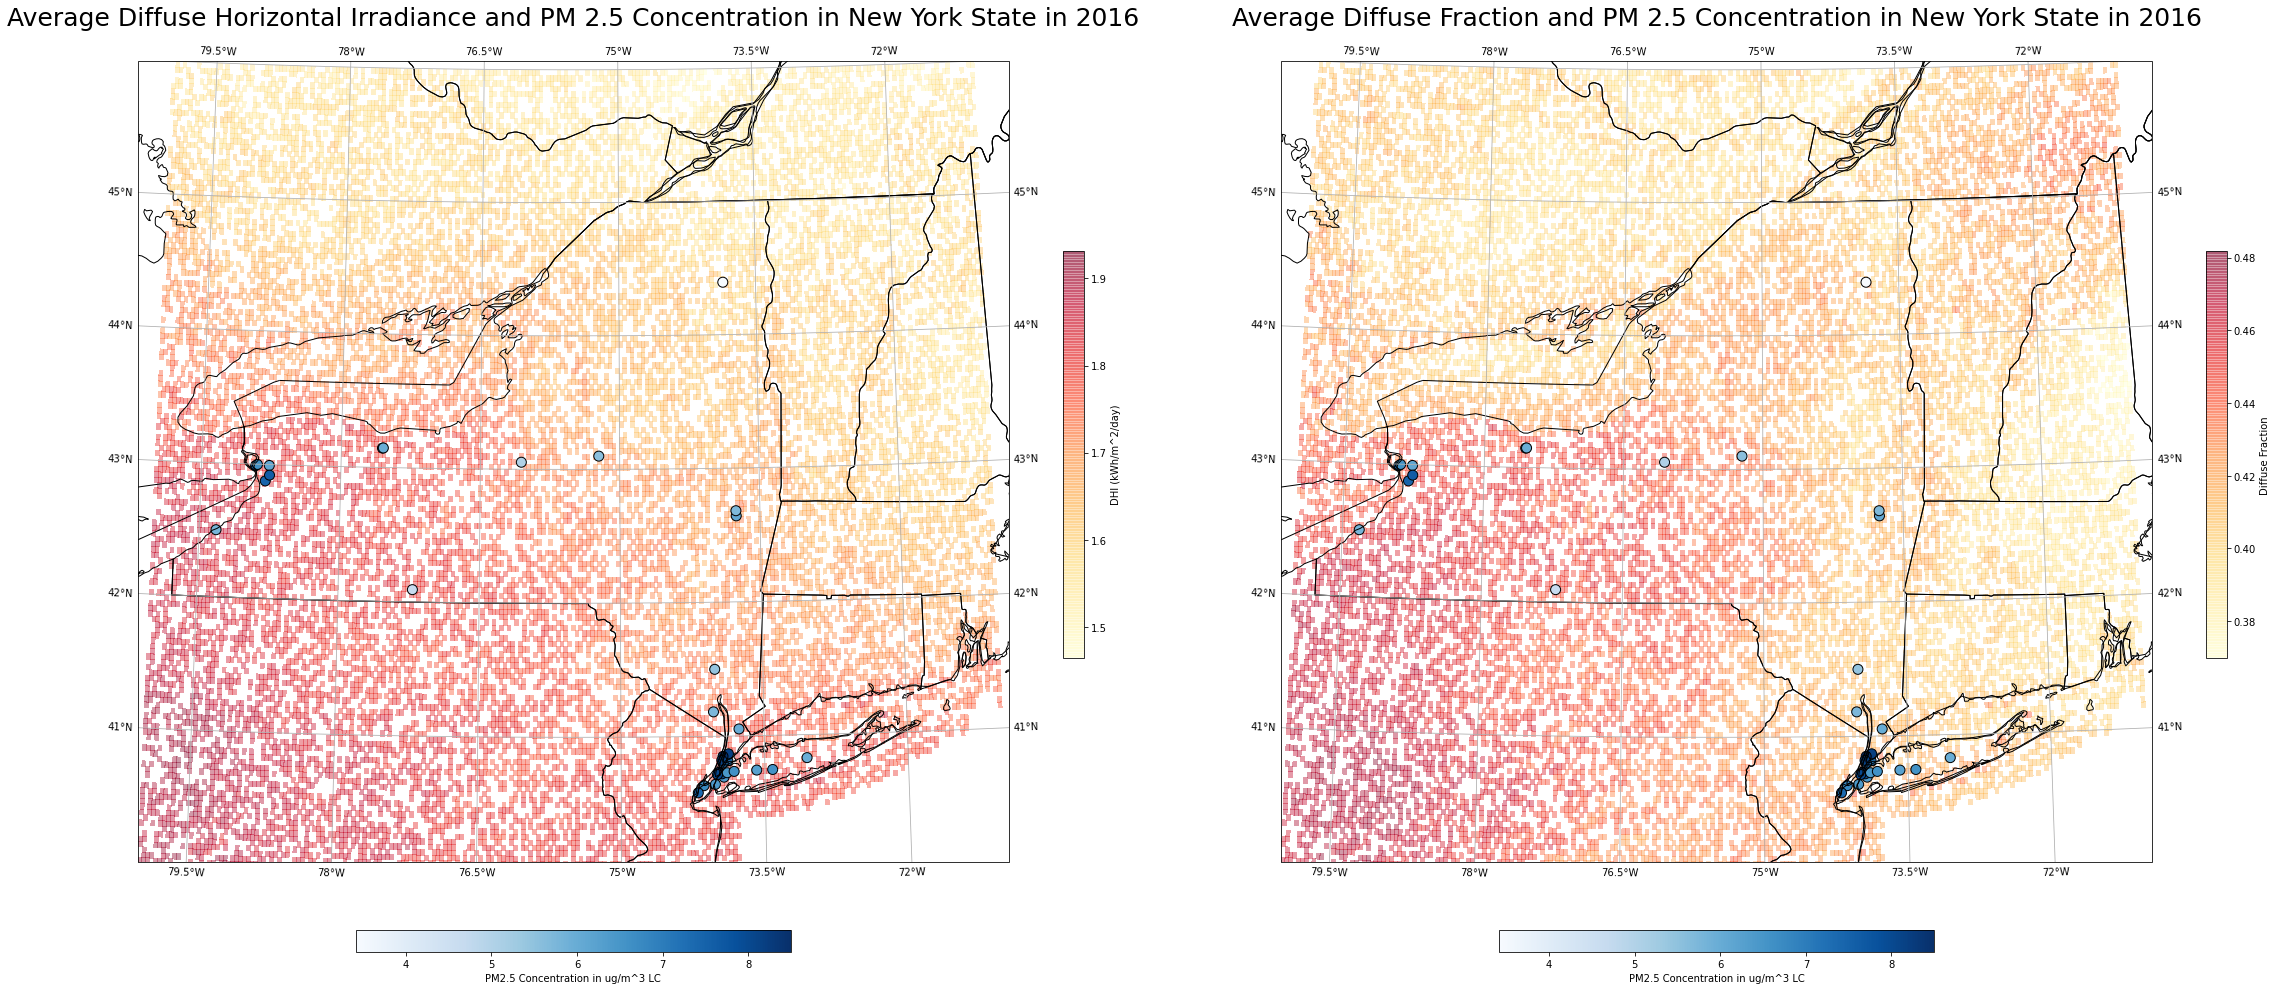

In [12]:
extent = [-80,-71, 40,46]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
fig, axes = plt.subplots(ncols=2,figsize=(40,25))
plt.subplots_adjust(wspace=0.05)

#Plot DHI with PM 2.5 

ax0 = plt.subplot(1,2,1,projection=ccrs.AlbersEqualArea(central_lon,central_lat))
ax0.set_extent(extent)
ax0.gridlines(draw_labels=True)
ax0.coastlines(resolution='50m')
ax0.add_feature(cfeature.BORDERS)
ax0.add_feature(cfeature.STATES)

NY_dhi.plot(ax=ax0,cmap='YlOrRd',vmin=np.min(NY_dhi),vmax=np.max(NY_dhi),transform=ccrs.PlateCarree(),alpha=0.4,cbar_kwargs={'shrink': 0.3,'label':'DHI (kWh/m^2/day)','pad':0.05})
plt.title('Average Diffuse Horizontal Irradiance and PM 2.5 Concentration in New York State in 2016',fontsize='25',pad='20')

sc0=ax0.scatter(site_mean.SITE_LONGITUDE,site_mean.SITE_LATITUDE,c=site_mean['Daily Mean PM2.5 Concentration'],cmap='Blues',transform=ccrs.PlateCarree(),s=100,marker='o',edgecolors='k')
plt.colorbar(sc0,shrink=0.5,label='PM2.5 Concentration in ug/m^3 LC',orientation = 'horizontal',pad=0.05)

#Plot diffuse fraction with PM2.5

ax1 = plt.subplot(1,2,2,projection=ccrs.AlbersEqualArea(central_lon,central_lat))
ax1.set_extent(extent)
ax1.gridlines(draw_labels=True)
ax1.coastlines(resolution='50m')
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.STATES)

NY_df.plot(ax=ax1,cmap='YlOrRd',vmin=np.min(NY_df),vmax=np.max(NY_df),transform=ccrs.PlateCarree(),alpha=0.4,cbar_kwargs={'shrink': 0.3,'label':'Diffuse Fraction','pad':0.05})
plt.title('Average Diffuse Fraction and PM 2.5 Concentration in New York State in 2016',fontsize='25',pad='20')

sc1=ax1.scatter(site_mean.SITE_LONGITUDE,site_mean.SITE_LATITUDE,c=site_mean['Daily Mean PM2.5 Concentration'],cmap='Blues',transform=ccrs.PlateCarree(),s=100,marker='o',edgecolors='k',)
plt.colorbar(sc1,shrink=0.5,label='PM2.5 Concentration in ug/m^3 LC',orientation = 'horizontal',pad=0.05)


- Find the maximum annual average PM2.5 Concentration over New York State

In [13]:
max(site_mean['Daily Mean PM2.5 Concentration'])

8.499700598802395

#### - An annual average PM2.5 concentration above 10 μg/m3 is considered as unhealthy air while the max of NY state is 8.5 μg/m3, so NY state has overall quality air in 2016.

#### - From the plots above we see that Buffalo and New York City have relatively higher average PM 2.5 concentration (dark blue circles). In the Diffuse Horizontal Irradiance plot we see the darkness of blue circles kind of match with the darkness of irradiance color and it indicates that higher concentration of PM 2.5 could result in more diffuse irradiance. But when it comes the Diffuse Fraction plot, the correlation between diffuse fraction and PM 2.5 concentration was not that obvious.

#### - There are also many circles overlapped around New York City area and a close-up would be helpful.

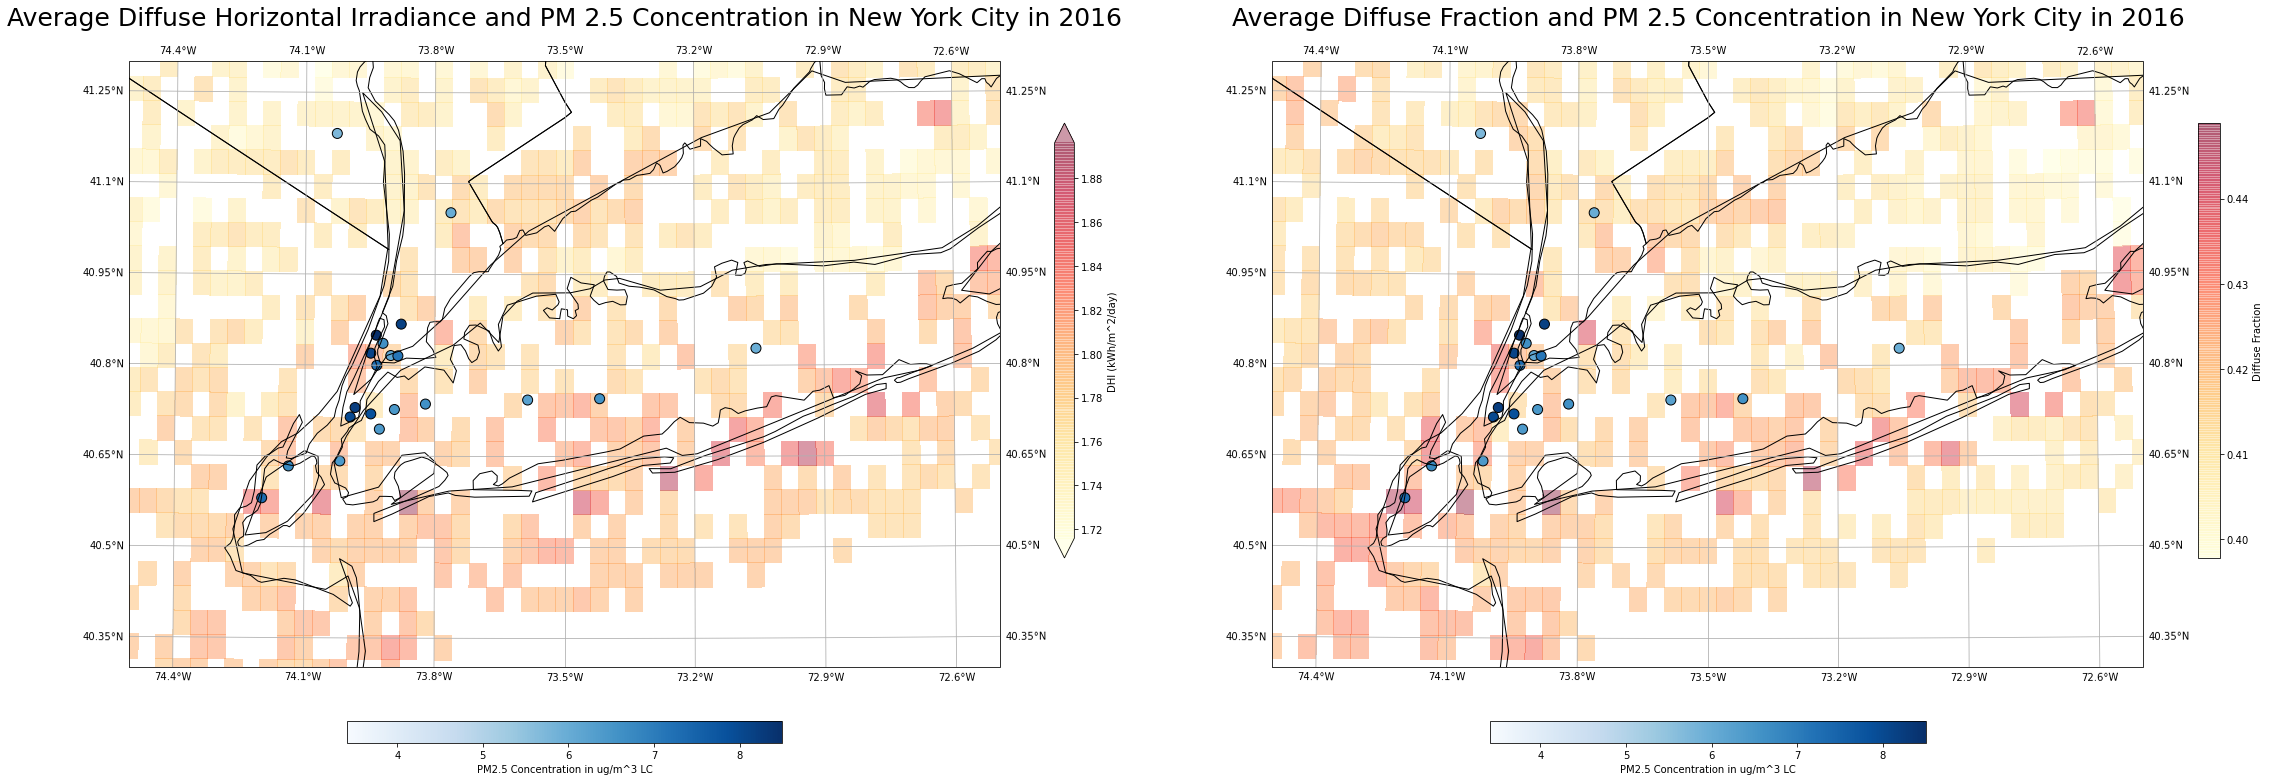

In [14]:
#New York City close-up

extent = [-74.5,-72.5, 40.3,41.3]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
fig, axes = plt.subplots(ncols=2,figsize=(40,20))
plt.subplots_adjust(wspace=0.05)

#DHI with PM 2.5 

ax0 = plt.subplot(1,2,1,projection=ccrs.AlbersEqualArea(central_lon,central_lat))
ax0.set_extent(extent)
ax0.gridlines(draw_labels=True)
ax0.coastlines(resolution='50m')
ax0.add_feature(cfeature.BORDERS)
ax0.add_feature(cfeature.STATES)

NYC_dhi=NY_dhi.sel(LAT=slice(40.3,41.3),LON=slice(-74.5,-72.5))
NY_dhi.plot(ax=ax0,cmap='YlOrRd',vmin=np.min(NYC_dhi),vmax=np.max(NYC_dhi),transform=ccrs.PlateCarree(),alpha=0.4,cbar_kwargs={'shrink': 0.4,'label':'DHI (kWh/m^2/day)','pad':0.05})
plt.title('Average Diffuse Horizontal Irradiance and PM 2.5 Concentration in New York City in 2016',fontsize='25',pad='20')

sc0=ax0.scatter(site_mean.SITE_LONGITUDE,site_mean.SITE_LATITUDE,c=site_mean['Daily Mean PM2.5 Concentration'],cmap='Blues',transform=ccrs.PlateCarree(),s=100,marker='o',edgecolors='k')
plt.colorbar(sc0,shrink=0.5,label='PM2.5 Concentration in ug/m^3 LC',orientation = 'horizontal',pad=0.05)

#Diffuse fraction with PM2.5

ax1 = plt.subplot(1,2,2,projection=ccrs.AlbersEqualArea(central_lon,central_lat))
ax1.set_extent(extent)
ax1.gridlines(draw_labels=True)
ax1.coastlines(resolution='50m')
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.STATES)

NYC_df = NY_df.sel(LAT=slice(40.3,41.3),LON=slice(-74.5,-72.5))
NYC_df.plot(ax=ax1,cmap='YlOrRd',vmin=np.min(NYC_df),vmax=np.max(NYC_df),transform=ccrs.PlateCarree(),alpha=0.4,cbar_kwargs={'shrink': 0.4,'label':'Diffuse Fraction','pad':0.05})
plt.title('Average Diffuse Fraction and PM 2.5 Concentration in New York City in 2016',fontsize='25',pad='20')

sc1=ax1.scatter(site_mean.SITE_LONGITUDE,site_mean.SITE_LATITUDE,c=site_mean['Daily Mean PM2.5 Concentration'],cmap='Blues',transform=ccrs.PlateCarree(),s=100,marker='o',edgecolors='k')
plt.colorbar(sc1,shrink=0.5,label='PM2.5 Concentration in ug/m^3 LC',orientation = 'horizontal',pad=0.05)


#### - Due to the lack of irradiance data points we cannot view the relationship very well. It seems that relatively higher diffuse irradiance and diffuse fraction comes with higher PM 2.5 concentration in Manhattan area and also on the edge of Staten Island.

#### - To further check if higher diffuse irradiance and diffuse fraction goes with higher PM 2.5 concentration, I filtered three data arrays and only leave data with high values.

In [15]:
#Get high DHI, DF, and PM 2.5 concentration values.

NYC_high_dhi = NYC_dhi.where(NYC_dhi > 1.82)
NYC_high_df = NYC_df.where(NYC_df > 0.43)
site_high = site_mean.where(site_mean['Daily Mean PM2.5 Concentration'] > 7)

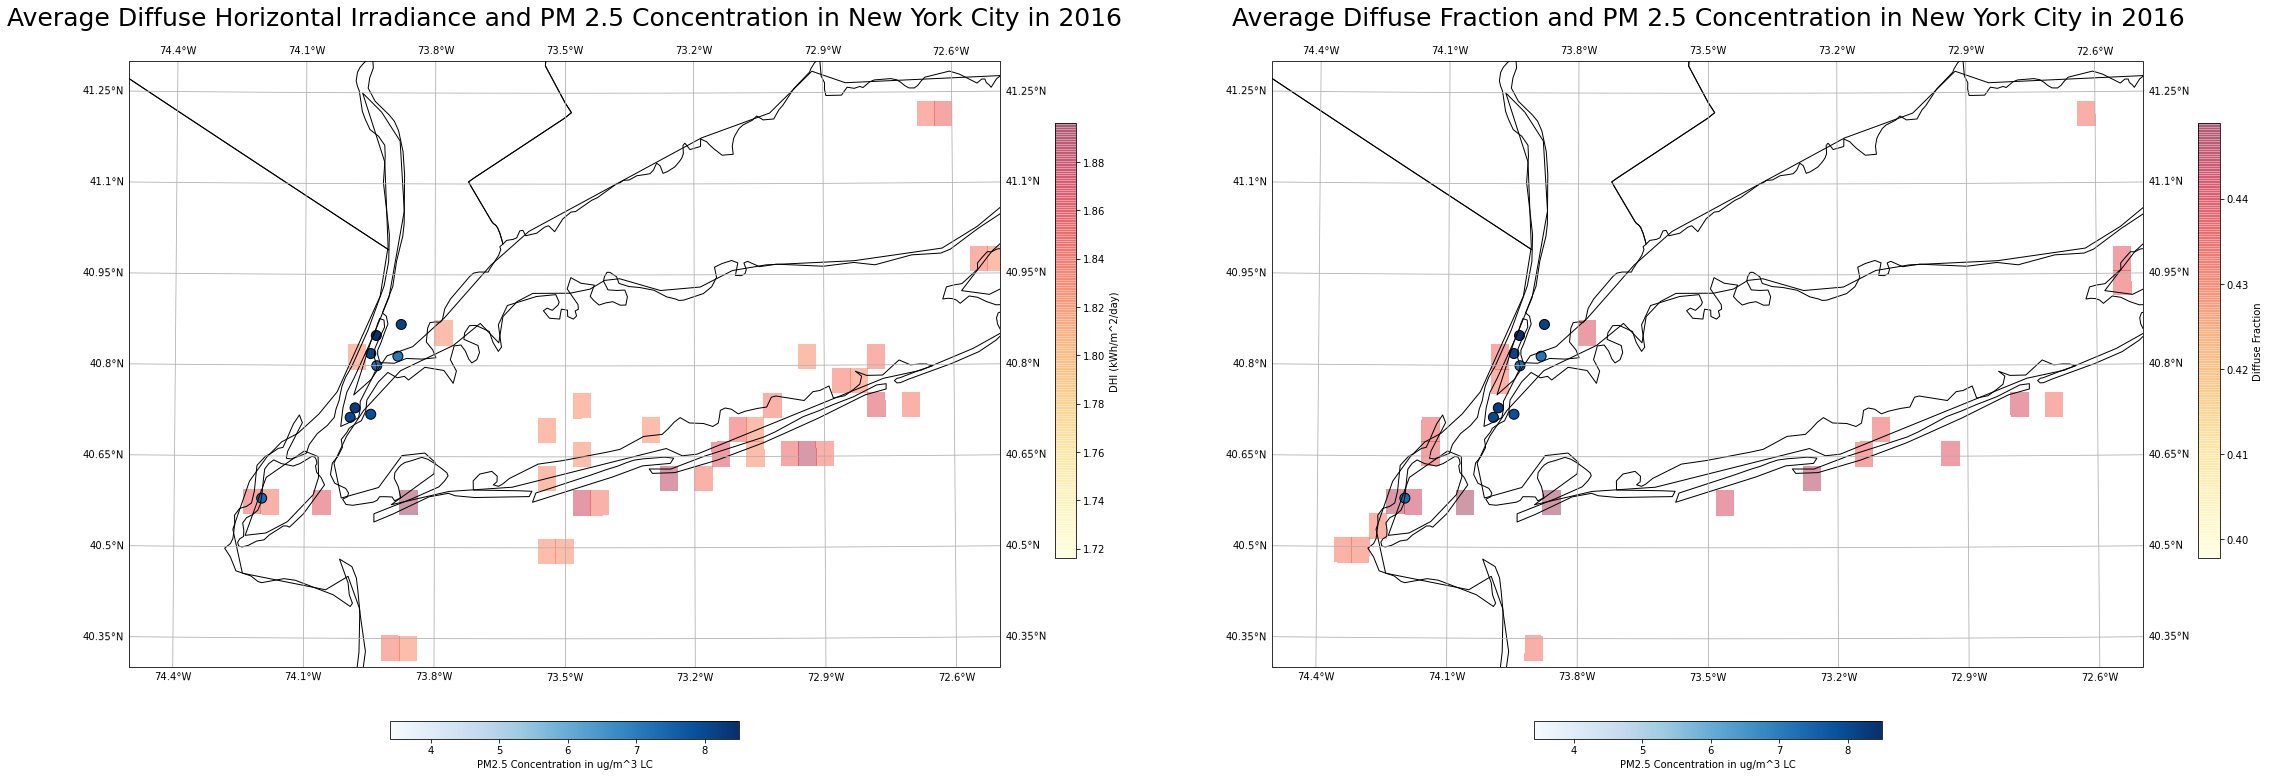

In [16]:
#New York City with only high DHI, DF, and PM 2.5 Concentration
#Color bars are left the same as above to see the filtered data points all have high values.

extent = [-74.5,-72.5, 40.3,41.3]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
fig, axes = plt.subplots(ncols=2,figsize=(40,20))
plt.subplots_adjust(wspace=0.05)

#DHI with PM 2.5 

ax0 = plt.subplot(1,2,1,projection=ccrs.AlbersEqualArea(central_lon,central_lat))
ax0.set_extent(extent)
ax0.gridlines(draw_labels=True)
ax0.coastlines(resolution='50m')
ax0.add_feature(cfeature.BORDERS)
ax0.add_feature(cfeature.STATES)

NYC_high_dhi.plot(ax=ax0,cmap='YlOrRd',vmin=np.min(NYC_dhi),vmax=np.max(NYC_dhi),transform=ccrs.PlateCarree(),alpha=0.4,cbar_kwargs={'shrink': 0.4,'label':'DHI (kWh/m^2/day)','pad':0.05})
plt.title('Average Diffuse Horizontal Irradiance and PM 2.5 Concentration in New York City in 2016',fontsize='25',pad='20')

sc0=ax0.scatter(site_high.SITE_LONGITUDE,site_high.SITE_LATITUDE,c=site_high['Daily Mean PM2.5 Concentration'],vmin=np.min(site_mean['Daily Mean PM2.5 Concentration']),vmax=np.max(site_mean['Daily Mean PM2.5 Concentration']),cmap='Blues',transform=ccrs.PlateCarree(),s=100,marker='o',edgecolors='k')
plt.colorbar(sc0,shrink=0.4,label='PM2.5 Concentration in ug/m^3 LC',orientation = 'horizontal',pad=0.05)

#Diffuse fraction with PM2.5

ax1 = plt.subplot(1,2,2,projection=ccrs.AlbersEqualArea(central_lon,central_lat))
ax1.set_extent(extent)
ax1.gridlines(draw_labels=True)
ax1.coastlines(resolution='50m')
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.STATES)

NYC_high_df.plot(ax=ax1,cmap='YlOrRd',vmin=np.min(NYC_df),vmax=np.max(NYC_df),transform=ccrs.PlateCarree(),alpha=0.4,cbar_kwargs={'shrink': 0.4,'label':'Diffuse Fraction','pad':0.05})
plt.title('Average Diffuse Fraction and PM 2.5 Concentration in New York City in 2016',fontsize='25',pad='20')

sc1=ax1.scatter(site_high.SITE_LONGITUDE,site_high.SITE_LATITUDE,c=site_high['Daily Mean PM2.5 Concentration'],vmin=np.min(site_mean['Daily Mean PM2.5 Concentration']),vmax=np.max(site_mean['Daily Mean PM2.5 Concentration']),cmap='Blues',transform=ccrs.PlateCarree(),s=100,marker='o',edgecolors='k')
plt.colorbar(sc1,shrink=0.4,label='PM2.5 Concentration in ug/m^3 LC',orientation = 'horizontal',pad=0.05)

#### - With limited number of data points shown above, it is possible that high PM 2.5 concentration has some positive effect on diffuse irradiance and diffuse fraction. I then fit them into linear regression models to further investigate the correlation.

### 4. Quantified Correlation Between PM 2.5 Concentration and DHI & DF

- Find corresponding DHI and diffuse fraction of the site locations with an approximation of 0.1 degrees

In [146]:
#First convert xarray to dataframe for easier comparison with site_mean dataframe

dhi = NY_dhi.to_dataframe(name='DHI')
dhi.reset_index(inplace=True)

dfrac=NY_df.to_dataframe(name='DF')
dfrac.reset_index(inplace=True)

In [147]:
#Add all DHI and DF values near each site location in to a dictionary

site_dhi = {}
site_df = {}
site_mean_index = site_mean.reset_index()# add index to site_mean

for i in range(len(dhi)):
    x=dhi.LON[i]
    y=dhi.LAT[i]
    m=dhi.DHI[i]
    n=dfrac.DF[i]
    if not np.isnan(m):
        for j in range(len(site_mean_index)):
            if math.isclose(y,site_mean_index.SITE_LATITUDE[j], abs_tol=0.1) and math.isclose(x, site_mean_index.SITE_LONGITUDE[j], abs_tol=0.1):
                if j in site_dhi:
                    site_dhi[j].append(m)
                    site_df[j].append(n)
                else:
                    site_dhi[j] = [m]
                    site_df[j] = [n]          

In [150]:
#Calculate average DHI and DF for each site location

for k in site_dhi.keys():
    site_dhi[k] = np.mean(site_dhi[k])
    site_df[k] = np.mean(site_df[k])

site_dhi

{30: 1.8040000000000005,
 29: 1.8064615384615388,
 13: 1.795636363636364,
 14: 1.7950000000000002,
 15: 1.7990769230769235,
 21: 1.796727272727273,
 22: 1.796727272727273,
 27: 1.7990000000000004,
 28: 1.7923636363636364,
 18: 1.7978181818181822,
 33: 1.8008571428571432,
 3: 1.7976000000000003,
 4: 1.7976000000000003,
 19: 1.795636363636364,
 23: 1.795636363636364,
 34: 1.7901818181818185,
 2: 1.7945454545454547,
 20: 1.7945454545454547,
 5: 1.7892000000000003,
 35: 1.7722500000000003,
 31: 1.7520000000000002,
 26: 1.7261538461538466,
 32: 1.806,
 6: 1.8549999999999998,
 0: 1.7103529411764709,
 1: 1.70775,
 8: 1.8130000000000004,
 9: 1.8145714285714287,
 10: 1.800923076923077,
 7: 1.8120000000000003,
 11: 1.8030000000000002,
 25: 1.7413333333333332,
 24: 1.7064000000000004,
 16: 1.8008000000000002,
 17: 1.8008000000000002,
 12: 1.6178181818181818}

In [151]:
site_df

{30: 0.4309532198778985,
 29: 0.42983465038246804,
 13: 0.42321573678724334,
 14: 0.4219869958059708,
 15: 0.42336520319118875,
 21: 0.4234385940442795,
 22: 0.4234385940442795,
 27: 0.42214356247588025,
 28: 0.41935158093984987,
 18: 0.41829621619496715,
 33: 0.42122849805930124,
 3: 0.42271954897910485,
 4: 0.42271954897910485,
 19: 0.4231702862918436,
 23: 0.4231702862918436,
 34: 0.41735381560251317,
 2: 0.4231439741358814,
 20: 0.4231439741358814,
 5: 0.4210134388502724,
 35: 0.4147112552295617,
 31: 0.4140965161818264,
 26: 0.41046518307330704,
 32: 0.44610436001102066,
 6: 0.45230768093191376,
 0: 0.41748308394319483,
 1: 0.41674359134712724,
 8: 0.4435067635829722,
 9: 0.4451464304358504,
 10: 0.4382796926832149,
 7: 0.4448004651381217,
 11: 0.43918991745433694,
 25: 0.4439303180263313,
 24: 0.43539992296650987,
 16: 0.4480676242696687,
 17: 0.4480676242696687,
 12: 0.41416387764657253}

In [181]:
#Convert DHI and DF dictionaries to data series and sort the values by site index for easier comparison

df0= pd.DataFrame(list(site_dhi.items()),columns = ['index','dhi']) 
df0= df0.sort_values(by='index')
site_dhi_mean= df0.set_index('index')

df1= pd.DataFrame(list(site_df.items()),columns = ['index','df']) 
df1= df1.sort_values(by='index')
site_dfrac_mean= df1.set_index('index')

- Run the linear regression model

In [193]:
#Convert data series to 2D array for LinearRegression()

site_dhi_np = site_dhi_mean.dhi.to_numpy()
y1= site_dhi_np.reshape(-1,1)

site_dfrac_np = site_dfrac_mean.df.to_numpy()
y2= site_dfrac_np.reshape(-1,1)

site_pm_np = site_mean_index['Daily Mean PM2.5 Concentration'].to_numpy()
x= site_pm_np.reshape(-1,1)

#DHI vs PM 2.5

reg1=LinearRegression().fit(x,y1) 
yfit1=reg1.predict(x)

#DF vs PM 2.5

reg2=LinearRegression().fit(x,y2)
yfit2=reg2.predict(x) 

- Get R squares for each model

In [192]:
#R^2 for DHI vs PM 2.5 model
print(reg1.score(x,y1))

#R^2 for DF vs PM 2.5
print(reg2.score(x,y2))

0.33975875640511244
0.000402382487533548


- Visualize the linear regression model results

Text(0.5, 1.0, 'Diffuse Fraction over PM 2.5 concentration (New York State 2016)')

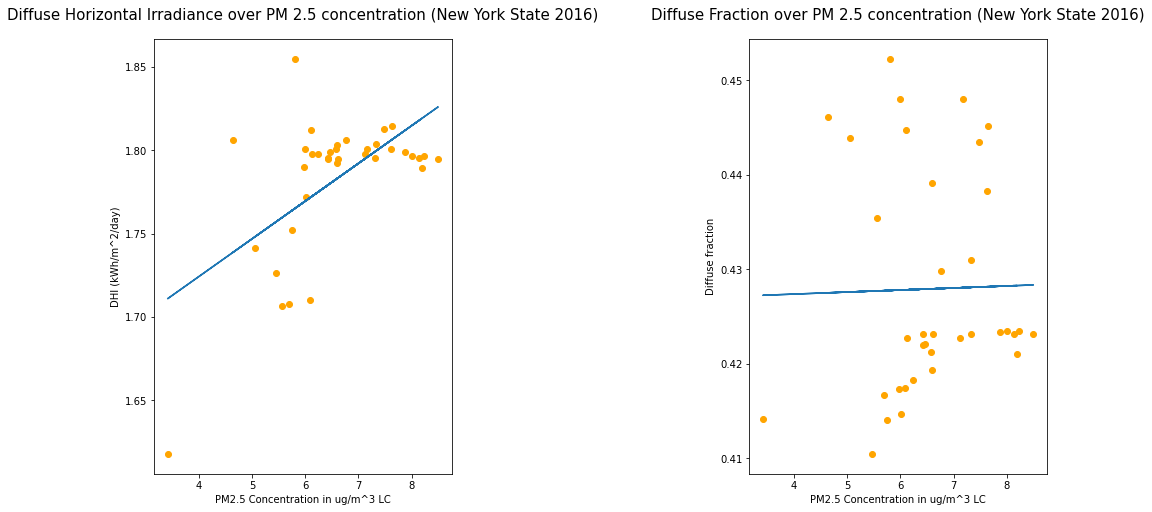

In [214]:
fig, axes = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=1)
ax0,ax1=axes

#DHI vs PM 2.5

ax0.scatter(x, y1,c='orange')
ax0.plot(x, yfit1)
ax0.set_xlabel('PM2.5 Concentration in ug/m^3 LC')
ax0.set_ylabel('DHI (kWh/m^2/day)')
ax0.set_title('Diffuse Horizontal Irradiance over PM 2.5 concentration (New York State 2016)',fontsize='15',pad='20')

#DF vs PM 2.5

ax1.scatter(x, y2,c='orange')
ax1.plot(x, yfit2)
ax1.set_xlabel('PM2.5 Concentration in ug/m^3 LC')
ax1.set_ylabel('Diffuse fraction')
ax1.set_title('Diffuse Fraction over PM 2.5 concentration (New York State 2016)',fontsize='15',pad='20')


#### - From the plot above, we see that diffuse horizontal irradiance is positively related to PM 2.5 concentration with an R square of 0.34, but for diffuse fraction there is alomost no correlation with PM 2.5 concentration as R square is close to 0. 

#### - The paper that studied  "Characteristics of Surface Solar Radiation under Different Air Pollution Conditions over Nanjing, China" got a R sqaure equals to 0.47 for diffuse fraction over PM 2.5 concentration, and this large discrepency could be resulted from three reasons: 1. irradiance and PM 2.5 concentration data points are limited; 2. The annual average irradiance data used includes both clear-sky and cloud conditions and so could not exclude the cloud effect in diffusion; 3. New York state has much lower PM 2.5 concentration than Nanjing (annual average <10 ug/m^3) and this could also affect the results.

#### -Thank you very much!